___

<a href='https://www.capitalbikeshare.com'> <img src='CapitalBikeshare_Logo.jpg' /></a>

___

<h1 align="center"><a href='https://www.kaggle.com/c/bike-sharing-demand'>Kaggle Competition Project</a></h1> 
___

# 1. Goal


Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


___

** Import Apache Spark 2.1libraries and setup environment variables. In case for cluster deployment you should probably remove this cell. **

In [435]:
import os
import sys
import time

# Change to path where apache spark 2.x is downloaded
SPARK_PATH = '/users/suchy/Documents/spark-2.1.0-bin-hadoop2.7'
os.environ['SPARK_HOME'] = SPARK_PATH

SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.4-src.zip"))

** Initialize Spark Context for driver program **

In [436]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

conf = (SparkConf()
         .setAppName("Capital_Bike_weather_mining")
        .set("spark.executor.memory", "4g")
        .set("spark.driver.memory", "8g"))
        #.setMaster("yarn") - for cluster deployment
    
SpContext = SparkContext.getOrCreate(conf = conf)
SqlContext = SQLContext(SpContext)
SpContext = SpContext.setCheckpointDir("checkpoint")

** Import pandas, numpy, matplotlib,and seaborn. Then set %matplotlib inline **

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

___
# 2. Get the Data
___

We are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields:

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals
<img src='bikes.png' /></a>

** Read in the Customers Bike Rental csv train and test files as a Pandas DataFrame.**

In [438]:
train_df = pd.read_csv("train.csv")

In [439]:
test_df = pd.read_csv("test.csv")

** There are 3 dependent variables: casual, registered and count (casual + registered) **. 

** We will try both methods: predict amount of casual and regitered rentals separately and predict sum of those (count) **

In [440]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [441]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


** Check out customers rental info() and describe() methods. Thera are total 10866 entries for traing data and 6493 entries for test data, none of the column has missing values**

In [442]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [443]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [444]:
continuous_var = ['temp', 'atemp', 'humidity', 'windspeed'] 

# exclude binary variables
categorical_var=['season','weather','year','month','hour','dayofweek','weekofyear','quarter','hour_cat', 'temp_cat']

dependent_variables = ['casual', 'registered', 'count']

added_cat_var = ['season_cat', 'month_cat', 'dayofweek_cat', 'weather_cat']


seasonDict = {1: "Winter", 2 : "Spring", 3 : "Summer", 4 :"Fall" }
monthDict = {1: "January", 2 : "February", 3 : "March", 4 :"April" ,\
             5 : "May", 6 : "June", 7 : "July", 8 :"August" ,\
             9: "September", 10 : "October", 11 : "November", 12 :"December"}
dayofweekDict = {0: "Monday", 1 : "Tuesday", 2 : "Wednesday", 3 :"Thursday" ,\
                 4 : "Friday", 5 : "Saturday", 6 : "Sunday"}
weatherDict = {1: "Clear", 2 : "Mist", 3 : "Light_Snow", 4 :"Heavy_Rain" }

** Data preparation part: parse data timestamp, add dummy and derivated variables. For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. So it's good idea to have categorical variables with similar level of unique values. ** 

**Lot's of data from the function below are taken in next section of Exploratory Data Analysis, like rental peak hours.**

In [452]:
def prepare_data(customers_rental, get_dummy=False, test_data=False, Kaggle = False):
    
    customers_rental['date'] = pd.to_datetime(customers_rental['datetime'])
    customers_rental["year"] = customers_rental["date"].dt.year
    customers_rental["month"] = customers_rental["date"].dt.month
    customers_rental["day"] = customers_rental["date"].dt.day
    customers_rental["hour"] = customers_rental["date"].dt.hour
    customers_rental["dayofweek"] = customers_rental["date"].dt.dayofweek
    customers_rental["weekofyear"] = customers_rental["date"].dt.weekofyear
    
    customers_rental["season_cat"] = customers_rental["season"].map(seasonDict)
    customers_rental["month_cat"] = customers_rental["month"].map(monthDict)    
    customers_rental["dayofweek_cat"] = customers_rental["dayofweek"].map(dayofweekDict)
    customers_rental["weather_cat"] = customers_rental["weather"].map(weatherDict)
    
    customers_rental['atemp_temp_diff'] = customers_rental['atemp'] - customers_rental['temp']
    
    # next_hour_weather is category for next hour weather 
    next_hour_weather = customers_rental['weather'].copy()
    next_hour_weather[:len(next_hour_weather)-1] = next_hour_weather[1:len(next_hour_weather)]
    customers_rental['next_hour_weather'] = next_hour_weather.reset_index()['weather']
    
    
    # create derivate variable: day-to-day and hour change for continuous variables
    for var in continuous_var:
        customers_rental[var+'_day_change_pct'] = customers_rental[var].pct_change(periods=24) * 100
        # to make positive values means percentage increase of variable in next hour
        customers_rental[var+'_next_hour_change_pct'] = customers_rental[var].pct_change(periods=-1)*(-1) * 100
        # two below variables are used to detect anomalies / outliers
        customers_rental[var+'_hour_change_pct'] = customers_rental[var].pct_change(periods=1) * 100
        customers_rental[var+'next_day_change_pct'] = customers_rental[var].pct_change(periods=-24) * 100
    
    customers_rental['quarter'] = 0
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 0), 'quarter'] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 3), 'quarter'] = 2
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 6), 'quarter'] = 3
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 9), 'quarter'] = 4
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 0), 'quarter'] = 5
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 3), 'quarter'] = 6
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 6), 'quarter'] = 7
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 9), 'quarter'] = 8
    
    
    # create additional variable about rental traffic by hour, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['hour_cat'] = 0
    customers_rental.loc[(customers_rental['hour'] <= 6) | (customers_rental['hour'] == 23), 'hour_cat'] = 1
    customers_rental.loc[(customers_rental['hour'] >= 7) & (customers_rental['hour'] <= 8) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 2
    customers_rental.loc[(customers_rental['hour'] >= 7) & (customers_rental['hour'] <= 8) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 3
    customers_rental.loc[((customers_rental['hour'] >= 20) & (customers_rental['hour'] <= 22)) | \
                         (customers_rental['hour'] == 9), 'hour_cat'] = 4
    customers_rental.loc[(customers_rental['hour'] >= 10) & (customers_rental['hour'] <= 16) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 5
    customers_rental.loc[(customers_rental['hour'] >= 10) & (customers_rental['hour'] <= 16) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 6
    customers_rental.loc[(customers_rental['hour'] >= 17) & (customers_rental['hour'] <= 18) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 7
    customers_rental.loc[(customers_rental['hour'] >= 17) & (customers_rental['hour'] <= 18) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 8
    
    # create additional variable about rental traffic by temp, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['temp_cat'] = 0
    customers_rental.loc[(customers_rental['temp'].round() < 13), 'temp_cat'] = 1
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 19) & \
                         (customers_rental['workingday'] == 0), 'temp_cat'] = 2
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 19) & \
                         (customers_rental['workingday'] == 1), 'temp_cat'] = 3
    customers_rental.loc[(customers_rental['temp'].round() >= 20) & (customers_rental['temp'].round() <= 29) & \
                         (customers_rental['workingday'] == 0), 'temp_cat'] = 4
    customers_rental.loc[(customers_rental['temp'].round() >= 20) & (customers_rental['temp'].round() <= 29) & \
                         (customers_rental['workingday'] == 1), 'temp_cat'] = 5
    customers_rental.loc[(customers_rental['temp'].round() >= 30), 'temp_cat'] = 6
    
    # from EDA 
    customers_rental['bike_season'] = 0
    customers_rental.loc[(customers_rental['month'] >= 4) & (customers_rental['month'] <= 11), 'bike_season'] = 1

    # data taken from independent source weather
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "holiday"] = 1

    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "workingday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "workingday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 10) \
                     & (customers_rental['day'] == 30), "holiday"] = 1
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 26)), "workingday"] = 0
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 25) | \
                       (customers_rental['day'] == 26)), "holiday"] = 1

    #storms
    customers_rental.loc[(customers_rental['month'] == 2012) & (customers_rental['month'] == 5) \
                         & (customers_rental['day'] == 21), "holiday"] = 1
    #tornado
    customers_rental.loc[(customers_rental['month'] == 2012) & (customers_rental['month'] == 6) \
                         & (customers_rental['day'] == 1), "holiday"] = 1
    

    
    # create dummy variables (if needed)    
    if (get_dummy):
        customers_rental = pd.get_dummies(data=customers_rental, columns=categorical_var, drop_first=True)

    
    dt = pd.DatetimeIndex(customers_rental['datetime'])
    customers_rental.set_index(dt, inplace=True)
    # first day don't have pct_change, as well as there are some divide by zero operation (inf)
    customers_rental = customers_rental.replace([np.inf, -np.inf], np.nan)
    # replace nan by interpolating
    # first argument can't be zero for interpolation to works
    customers_rental.iloc[0] = customers_rental.iloc[0].fillna(0)
    customers_rental = customers_rental.interpolate(method='linear')
    #customers_rental = customers_rental.fillna(customers_rental.mean())
    
    
    # Apache Spark solver uses square loss function for minimalization. 
    # Our evalutation metric will be RMSLE so it's good idea to use logarithmic transformation 
    # of dependent cols (adding 1 first so that 0 values don't become -inf)
    if (not test_data):   
        for col in dependent_variables:
            customers_rental['%s_log' % col] = np.log(customers_rental[col] + 1)
            
    
            
    # drop unnecessary variables
    # leave datetime variable for Kaggle dataset, it will be used in submission file format
    if (Kaggle):
        customers_rental.drop(['date'], axis=1, inplace=True)
    else:
        customers_rental.drop(['datetime','date'], axis=1, inplace=True) 
        
    return customers_rental

** We will use dataset with dummy variables for linear regression **

In [453]:

all_dummy = prepare_data(train_df.copy().append(test_df.copy()), get_dummy=True, test_data=True, Kaggle=True)

In [454]:
all_no_dummy = prepare_data(train_df.copy().append(test_df.copy()), get_dummy=False, test_data=True, Kaggle=True)

In [457]:
all_no_dummy[all_no_dummy['day'] >= 20].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 44 columns):
atemp                             6493 non-null float64
casual                            6493 non-null float64
count                             6493 non-null float64
datetime                          6493 non-null object
holiday                           6493 non-null int64
humidity                          6493 non-null int64
registered                        6493 non-null float64
season                            6493 non-null int64
temp                              6493 non-null float64
weather                           6493 non-null int64
windspeed                         6493 non-null float64
workingday                        6493 non-null int64
year                              6493 non-null int64
month                             6493 non-null int64
day                               6493 non-null int64
hour                              

In [335]:
train_dummy = prepare_data(train_df.copy(), get_dummy=True)
test_dummy_KAGGLE = prepare_data(test_df.copy(), get_dummy=True, test_data=True, Kaggle=True)
all_dummy = prepare_data(train_df.drop(dependent_variables, axis=1).copy().append(test_df.copy()), get_dummy=True, test_data=True)

**We will use dataset without dummy varaibles for random forest regression and gradient boosted regression.**

In [336]:
train_no_dummy = prepare_data(train_df.copy(), get_dummy=False)
test_no_dummy_KAGGLE = prepare_data(test_df.copy(), get_dummy=False, test_data=True, Kaggle=True)
all_no_dummy = prepare_data(train_df.drop(dependent_variables, axis=1).copy().append(test_df.copy()), get_dummy=False, test_data=True)

** Columns structure (without dummies) after data preparation part. Later we will explore which set of those columns use for machine learning models. **

In [337]:
train_no_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 38 columns):
season                            10886 non-null int64
holiday                           10886 non-null int64
workingday                        10886 non-null int64
weather                           10886 non-null int64
temp                              10886 non-null float64
atemp                             10886 non-null float64
humidity                          10886 non-null int64
windspeed                         10886 non-null float64
casual                            10886 non-null int64
registered                        10886 non-null int64
count                             10886 non-null int64
year                              10886 non-null int64
month                             10886 non-null int64
day                               10886 non-null int64
hour                              10886 non-null int64
dayofweek                

# 3. Exploratory Data Analysis
** Let's explore the data! **

In [338]:
sns.set_palette("coolwarm")
sns.set_style('whitegrid')

** Median of continuous variables looks reasonably. There are many outliers in windspeed variable and some outliers for zero humidity. **

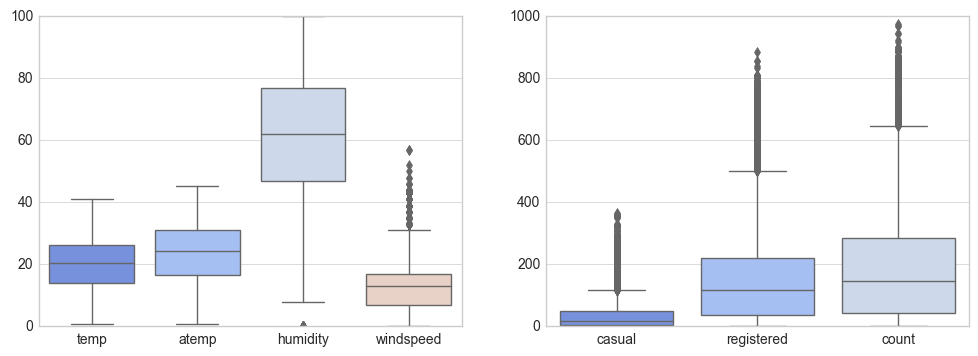

In [339]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(data=train_no_dummy[continuous_var], ax=ax1)
sns.boxplot(data=train_no_dummy[dependent_variables], ax=ax2)

### Let's dive deeper into each continuous variable
** Explore data of daily average of one hour bike rentals across all years 2011 and 2012. Sliding windows is of interval 14 days. ** 

In [413]:
outliers = {}

def plot_with_window(column, all=True, window=True):   
    if (all):
        data = all_no_dummy2
        data_window_mean = data.rolling(window=72).mean()
        data_window_std = data.rolling(window=72).std()
        
    else:
        data = train_no_dummy.groupby(['year','month','day']).mean()
        data_window_mean = data.rolling(window=7).mean()
        data_window_std = data.rolling(window=7).std()
    
    diff = np.abs(data[column] - data_window_mean[column])
    # diff for outliers candidates has to be at least 15% to avoid false outliers
    outliers = diff[(diff > 3 * data_window_std[column]) & (diff > 100)] #.index.values.tolist()

    plt.figure(figsize=(9,4))
    data[column].plot()
    data_window_mean[column].plot(label='3 Day Avg', lw=1, ls='--', c='red')
    
    plt.legend(loc='best')
    plt.ylabel(column)
    plt.title('Daily mean of ' + column + ' over time')
    plt.tight_layout()
    
    
    return outliers

In [341]:
def unique_outliers(col_list):
    outliers_list = []
    for col in col_list:
        for timestamp in outliers[col].index:
            outliers_list.append(timestamp)
    return sorted(list(set(outliers_list)))

** Characterics of casual renting is very changeable with many positive peaks. **

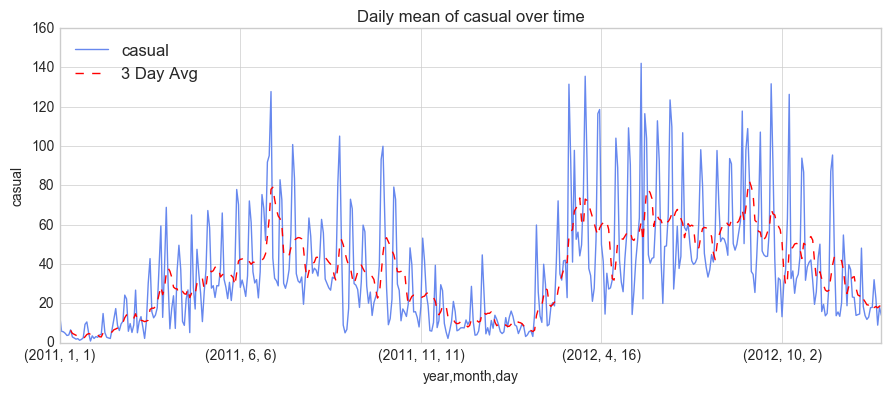

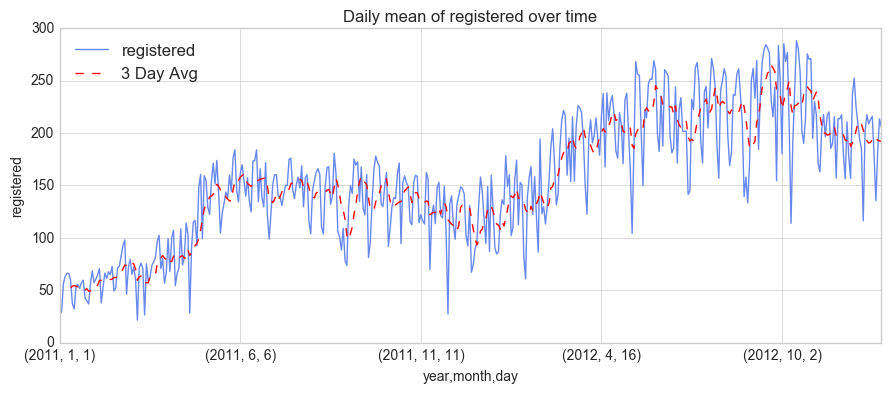

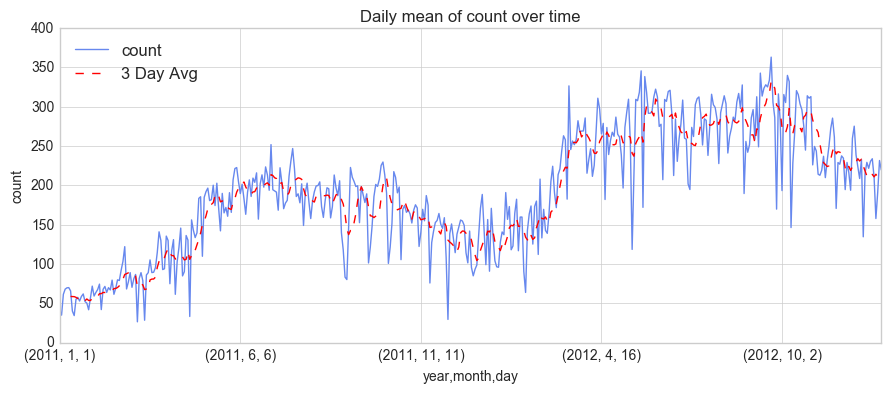

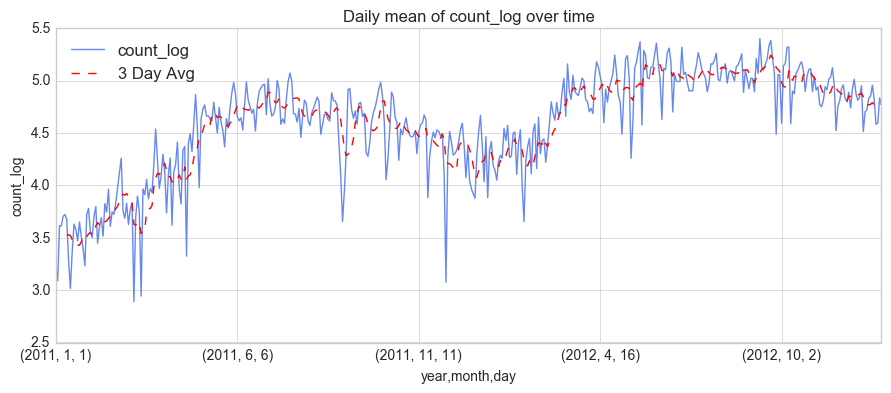

In [459]:
for col in dependent_variables + ['count_log']: 
    outliers[col] = plot_with_window(col, all=False)

** Plot for registred users looks almost the same becouse on average about 80% of total rentals are made be registered users. **

In [343]:
train_no_dummy[['casual', 'registered', 'count']].describe().ix['mean']

casual         36.021955
registered    155.552177
count         191.574132
Name: mean, dtype: float64

** Thera are no outliers for dependent variables **

In [344]:
all_no_dummy.ix[unique_outliers(dependent_variables)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weekofyear,season_cat,month_cat,dayofweek_cat,weather_cat,atemp_temp_diff,next_hour_weather,temp_day_change_pct,temp_next_hour_change_pct,atemp_day_change_pct,atemp_next_hour_change_pct,humidity_day_change_pct,humidity_next_hour_change_pct,windspeed_day_change_pct,windspeed_next_hour_change_pct,quarter,hour_cat,temp_cat,bike_season


** Let's find out whether there are some weather data outliers. **

In [345]:
temp_var_list = ['temp',          
            'temp_day_change_pct',             
            'temp_next_hour_change_pct']

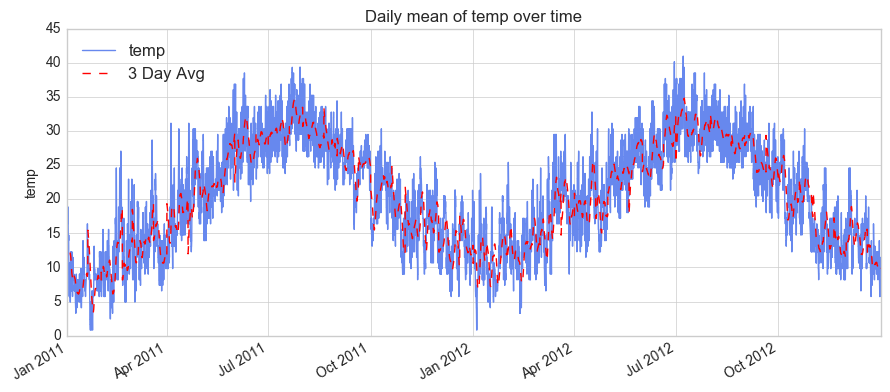

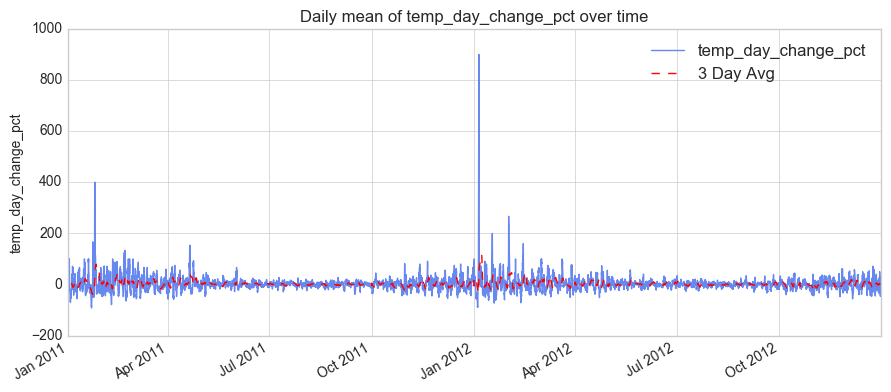

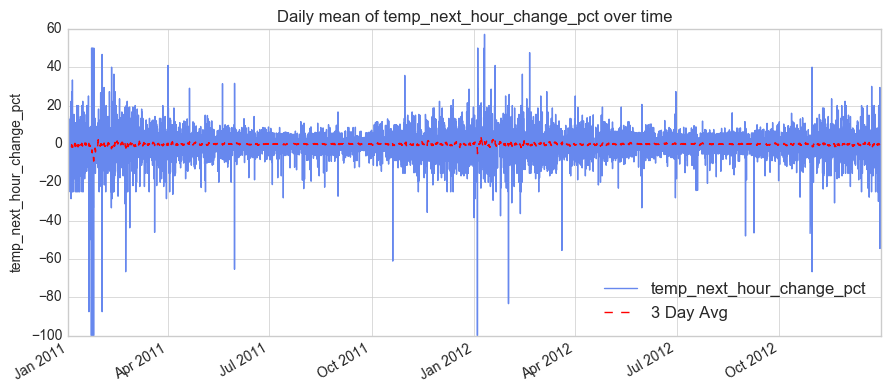

In [414]:
for col in temp_var_list: 
    outliers[col] = plot_with_window(col)

** Some of the outliers below. **

In [415]:
all_no_dummy.ix[unique_outliers(temp_var_list), temp_var_list].head()

,temp,temp_day_change_pct,temp_next_hour_change_pct
2011-01-23 08:00:00,2.46,200.000000,40.000000
2011-01-23 09:00:00,4.10,400.000000,28.571429
2011-01-23 10:00:00,5.74,250.000000,-0.000000
2011-01-23 11:00:00,5.74,250.000000,12.500000
2011-01-23 12:00:00,6.56,166.666667,-14.285714


In [416]:
atemp_var_list = ['atemp',
            'atemp_temp_diff',        
            'atemp_day_change_pct',             
            'atemp_next_hour_change_pct']

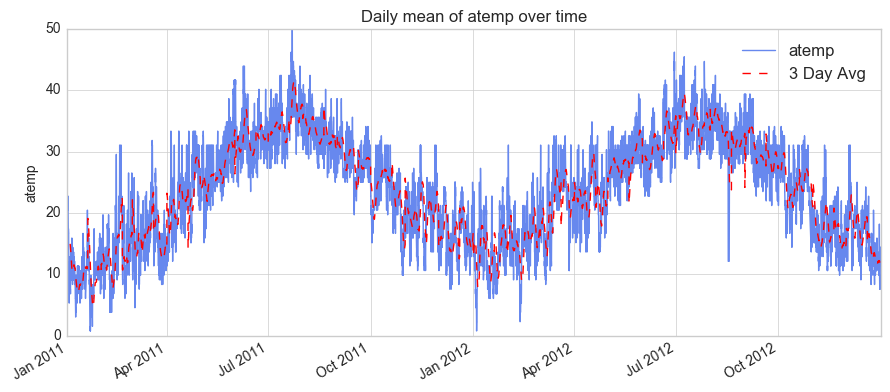

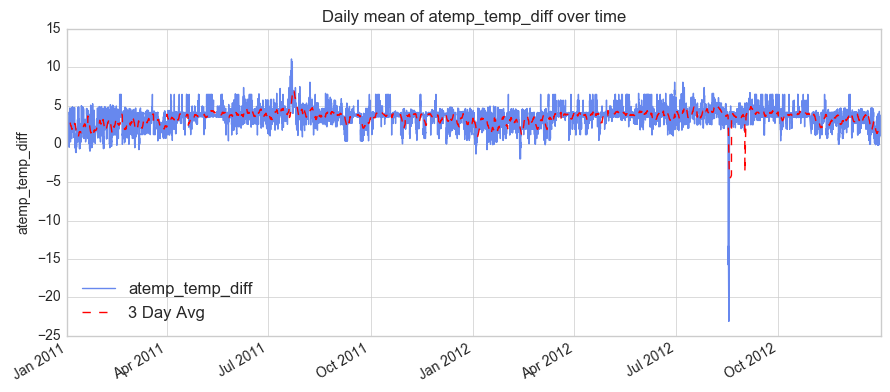

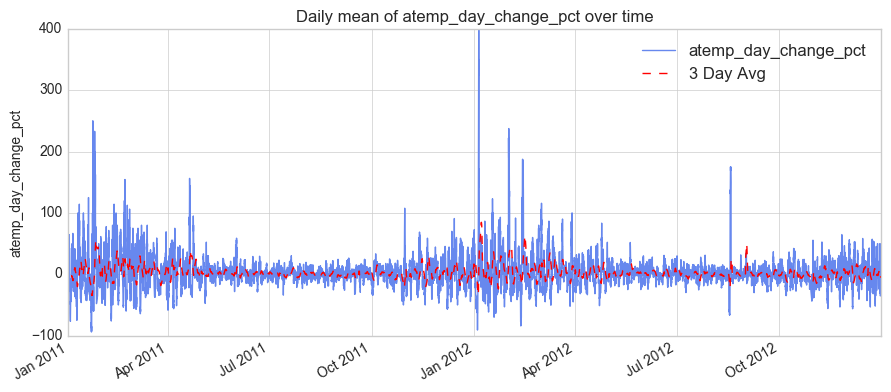

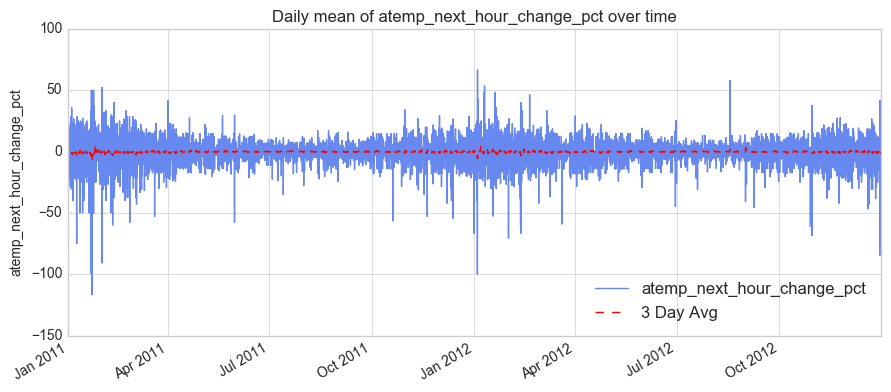

In [417]:
for col in atemp_var_list: 
    outliers[col] = plot_with_window(col)

In [418]:
all_no_dummy.ix[unique_outliers(atemp_var_list)][atemp_var_list].head()

,atemp,atemp_temp_diff,atemp_day_change_pct,atemp_next_hour_change_pct
2011-01-10 02:00:00,6.060,1.140,100.000000,-0.000000
2011-01-22 17:00:00,9.850,4.930,44.428152,-116.721672
2011-01-23 03:00:00,3.030,2.210,100.000000,20.052770
2011-01-23 10:00:00,5.305,-0.435,250.165017,22.214076
2011-01-25 02:00:00,7.575,1.015,232.967033,9.118176


** We can see one clear outlier in humidity. During minium day for count variable (2011, 3, 6), humidity had one of its highest value. It matches our understanding - there are fewer bike rentals during rain. On (2011, 3, 10) humidity has zero daily mean value although in adjacent days there was high value for humidity. It looks like some missing values. **

In [419]:
train_no_dummy.groupby(['year','month','day']).mean().idxmin()

season                             (2011, 1, 1)
holiday                            (2011, 1, 1)
workingday                         (2011, 1, 1)
weather                            (2011, 1, 3)
temp                               (2012, 1, 4)
atemp                             (2012, 2, 12)
humidity                          (2011, 3, 10)
windspeed                         (2011, 10, 7)
casual                            (2011, 1, 18)
registered                         (2011, 3, 6)
count                              (2011, 3, 6)
hour                               (2011, 1, 1)
dayofweek                          (2011, 1, 3)
weekofyear                         (2011, 1, 3)
atemp_temp_diff                   (2012, 8, 17)
next_hour_weather                  (2011, 1, 3)
temp_day_change_pct                (2011, 1, 3)
temp_next_hour_change_pct         (2012, 1, 18)
atemp_day_change_pct              (2012, 8, 17)
atemp_next_hour_change_pct        (2012, 2, 11)
humidity_day_change_pct           (2011,

In [420]:
humidity_var_list = ['humidity',            
            'humidity_day_change_pct',             
            'humidity_next_hour_change_pct']

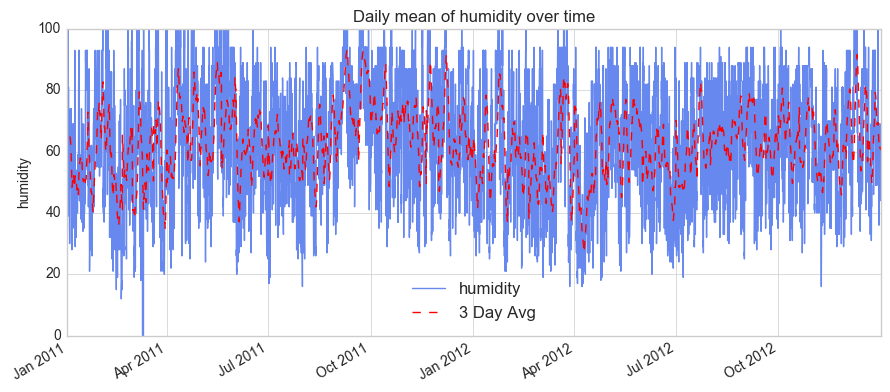

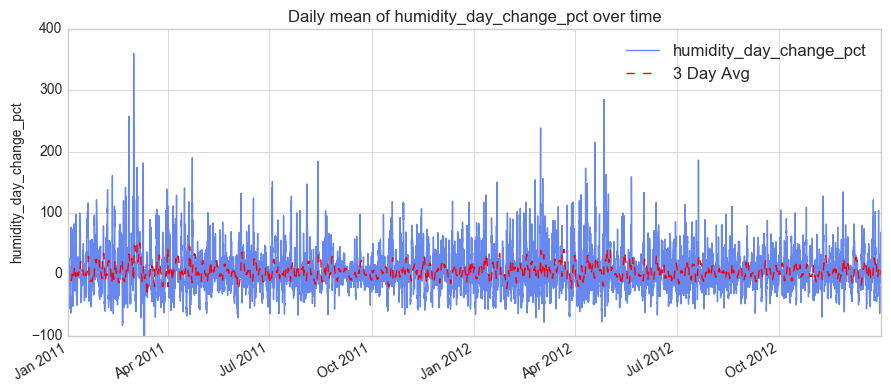

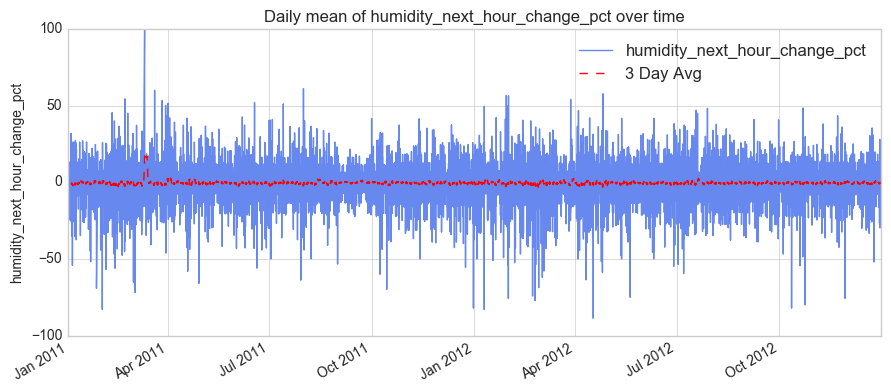

In [421]:
for col in humidity_var_list: 
    outliers[col] = plot_with_window(col)

In [422]:
all_no_dummy.ix[unique_outliers(humidity_var_list)][humidity_var_list].head()

,humidity,humidity_day_change_pct,humidity_next_hour_change_pct
2011-02-09 20:00:00,86,115.000000,-0.000000
2011-02-09 22:00:00,80,142.424242,-0.000000
2011-02-10 00:00:00,86,160.606061,-7.500000
2011-02-19 00:00:00,12,-83.333333,14.285714
2011-02-21 13:00:00,81,179.310345,-6.578947


** Windspeed becouse of its nature has very inregular characteriscs but in a way it has some stable mean level. Looks like this variable doesn't add value for our predictive models. **

In [423]:
windspeed_var_list = ['windspeed',            'windspeed_day_change_pct',             
            'windspeed_next_hour_change_pct']

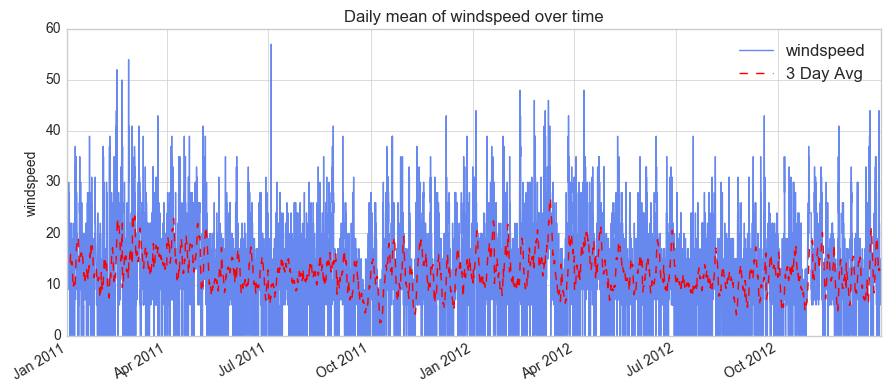

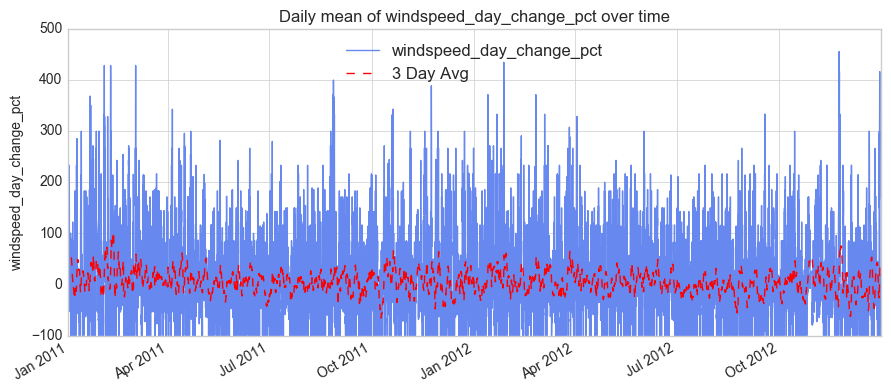

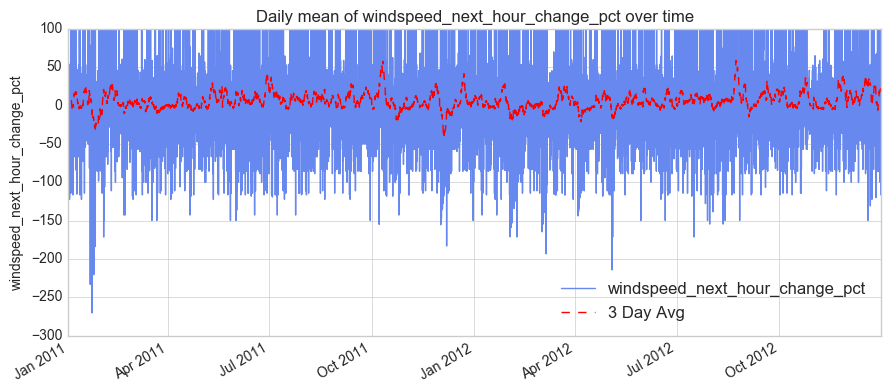

In [424]:
for col in windspeed_var_list: 
    outliers[col] = plot_with_window(col)

In [361]:
all_no_dummy.ix[unique_outliers(windspeed_var_list)][windspeed_var_list].head()

,windspeed,windspeed_day_change_pct,windspeed_next_hour_change_pct
2011-01-09 01:00:00,31.0009,416.406250,-0.000000
2011-01-09 09:00:00,35.0008,399.904306,-34.604483
2011-01-12 12:00:00,39.0007,254.506699,-62.506979
2011-01-12 14:00:00,22.0028,214.258373,21.416607
2011-01-12 15:00:00,27.9993,366.406250,-27.253350


### There are 671 outliers in total. Let's interpolate them. 

In [362]:
len(unique_outliers(humidity_var_list + temp_var_list + atemp_var_list + windspeed_var_list))

671

In [411]:
def interpolate_data(dataset):
    data = dataset.copy()
    for col_list in [humidity_var_list] + [temp_var_list] + [atemp_var_list] + [windspeed_var_list]:
        for col in col_list:
            for timestamp in outliers[col].index:
#                     for col2 in col_list:
                        data.loc[timestamp, col_list] = np.NaN

    data = data.interpolate(method='linear', axis=0)
#     data.info()
#     data.describe()
#     data = data.fillna(data.mean())
    return data

In [412]:
all_no_dummy2 = interpolate_data(all_no_dummy.copy())
all_dummy2 = interpolate_data(all_dummy.copy())

In [403]:
all_no_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 32 columns):
season                            17379 non-null int64
holiday                           17379 non-null int64
workingday                        17379 non-null int64
weather                           17379 non-null int64
temp                              17379 non-null float64
atemp                             17379 non-null float64
humidity                          17379 non-null int64
windspeed                         17379 non-null float64
year                              17379 non-null int64
month                             17379 non-null int64
day                               17379 non-null int64
hour                              17379 non-null int64
dayofweek                         17379 non-null int64
weekofyear                        17379 non-null int64
season_cat                        17379 non-null object
month_cat               

In [404]:
all_no_dummy2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 32 columns):
season                            17379 non-null int64
holiday                           17379 non-null int64
workingday                        17379 non-null int64
weather                           17379 non-null int64
temp                              17379 non-null float64
atemp                             17379 non-null float64
humidity                          17379 non-null float64
windspeed                         17379 non-null float64
year                              17379 non-null int64
month                             17379 non-null int64
day                               17379 non-null int64
hour                              17379 non-null int64
dayofweek                         17379 non-null int64
weekofyear                        17379 non-null int64
season_cat                        17379 non-null object
month_cat             

In [407]:
all_no_dummy.loc[('2012-01-10 03:00:00'):('2012-01-10 07:00:00')]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weekofyear,season_cat,month_cat,dayofweek_cat,weather_cat,atemp_temp_diff,next_hour_weather,temp_day_change_pct,temp_next_hour_change_pct,atemp_day_change_pct,atemp_next_hour_change_pct,humidity_day_change_pct,humidity_next_hour_change_pct,windspeed_day_change_pct,windspeed_next_hour_change_pct,quarter,hour_cat,temp_cat,bike_season
2012-01-10 04:00:00,1,0,1,2,8.20,10.605,86,11.0014,2012,1,10,4,1,2,Winter,January,Tuesday,Mist,2.405,1,-16.666667,50.000000,-12.500000,48.154485,65.384615,-82.978723,0.000000,26.663689,5,1,1,0
2012-01-10 05:00:00,1,0,1,1,16.40,20.455,47,15.0013,2012,1,10,5,1,2,Winter,January,Tuesday,Clear,4.055,2,81.818182,-122.222222,68.770627,-125.027503,-26.562500,49.462366,114.258373,-15.412371,5,1,3,0
2012-01-10 06:00:00,1,0,1,2,7.38,9.090,93,12.9980,2012,1,10,6,1,2,Winter,January,Tuesday,Mist,1.710,2,-10.000000,-0.000000,-20.017598,7.715736,45.312500,-0.000000,116.517857,-18.148599,5,1,1,0
2012-01-10 07:00:00,1,0,1,2,7.38,9.850,93,11.0014,2012,1,10,7,1,2,Winter,January,Tuesday,Mist,2.470,2,-18.181818,-0.000000,-13.330400,-0.000000,55.000000,-0.000000,22.263589,-0.000000,5,3,1,0


In [408]:
all_no_dummy2.ix[('2012-01-10 03:00:00'):('2012-01-10 07:00:00')]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weekofyear,season_cat,month_cat,dayofweek_cat,weather_cat,atemp_temp_diff,next_hour_weather,temp_day_change_pct,temp_next_hour_change_pct,atemp_day_change_pct,atemp_next_hour_change_pct,humidity_day_change_pct,humidity_next_hour_change_pct,windspeed_day_change_pct,windspeed_next_hour_change_pct,quarter,hour_cat,temp_cat,bike_season
2012-01-10 04:00:00,1,0,1,2,8.20,10.6050,86.0,11.0014,2012,1,10,4,1,2,Winter,January,Tuesday,Mist,2.4050,1,-16.666667,50.0,-12.500000,48.154485,65.384615,-82.978723,0.000000,26.663689,5,1,1,0
2012-01-10 05:00:00,1,0,1,1,7.79,9.8475,47.0,15.0013,2012,1,10,5,1,2,Winter,January,Tuesday,Clear,2.0575,2,-13.333333,25.0,-16.258799,27.935111,-26.562500,49.462366,114.258373,-15.412371,5,1,3,0
2012-01-10 06:00:00,1,0,1,2,7.38,9.0900,93.0,12.9980,2012,1,10,6,1,2,Winter,January,Tuesday,Mist,1.7100,2,-10.000000,-0.0,-20.017598,7.715736,45.312500,-0.000000,116.517857,-18.148599,5,1,1,0
2012-01-10 07:00:00,1,0,1,2,7.38,9.8500,93.0,11.0014,2012,1,10,7,1,2,Winter,January,Tuesday,Mist,2.4700,2,-18.181818,-0.0,-13.330400,-0.000000,55.000000,-0.000000,22.263589,-0.000000,5,3,1,0


In [310]:
len(list(train_no_dummy.index))

10886

In [308]:
def diff_list(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [312]:
diff_list(list(train_no_dummy2.index), list(train_no_dummy.index))

[Timestamp('2011-01-24 18:00:00'),
 Timestamp('2011-02-21 12:00:00'),
 Timestamp('2011-02-21 13:00:00'),
 Timestamp('2011-02-21 14:00:00'),
 Timestamp('2011-02-21 15:00:00'),
 Timestamp('2011-02-21 16:00:00'),
 Timestamp('2011-02-28 15:00:00'),
 Timestamp('2011-03-29 21:00:00'),
 Timestamp('2011-03-29 22:00:00'),
 Timestamp('2011-03-29 23:00:00'),
 Timestamp('2011-03-30 15:00:00'),
 Timestamp('2011-03-30 16:00:00'),
 Timestamp('2011-03-30 17:00:00'),
 Timestamp('2011-03-30 18:00:00'),
 Timestamp('2011-03-30 19:00:00'),
 Timestamp('2011-03-30 20:00:00'),
 Timestamp('2011-04-22 12:00:00'),
 Timestamp('2011-04-22 13:00:00'),
 Timestamp('2011-04-22 14:00:00'),
 Timestamp('2011-04-22 15:00:00'),
 Timestamp('2011-04-22 16:00:00'),
 Timestamp('2011-04-22 17:00:00'),
 Timestamp('2011-04-22 18:00:00'),
 Timestamp('2011-04-22 19:00:00'),
 Timestamp('2011-08-20 11:00:00'),
 Timestamp('2011-08-20 12:00:00'),
 Timestamp('2011-08-20 13:00:00'),
 Timestamp('2011-08-20 15:00:00'),
 Timestamp('2011-08-

___
** From the boxplot below its clear most bike rentals are  in hours: 8, 17, 18. We should expect that registred users rent bikes in those hours becouse there are almost no outliers. Between those hours there are hours with many outliers. We should expect that more casual users rent bikes in those hours  **

<function matplotlib.pyplot.tight_layout>

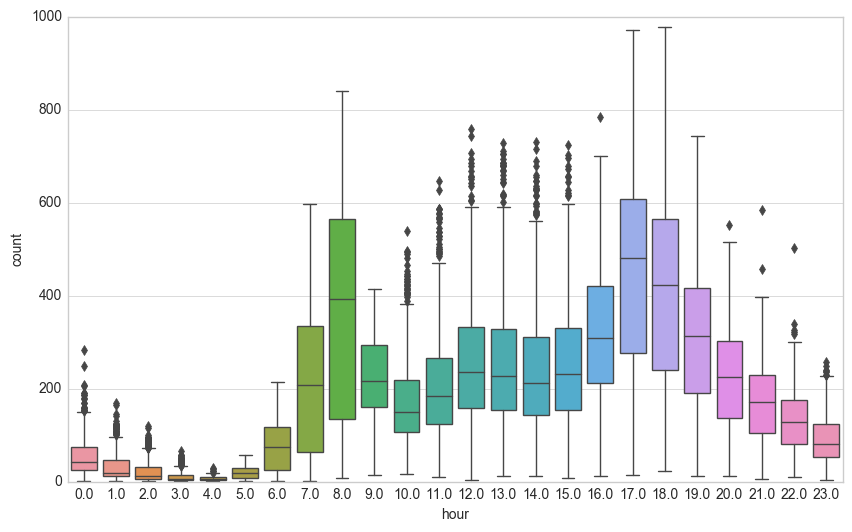

In [75]:
plt.figure(figsize=(10,6))
sns.boxplot(x="hour", y="count", data=train_no_dummy2)
plt.tight_layout

** On the plots below we can see rentals distribution for specifc month. Druing summer there are most demand for bikes. During all season hour-rental characteristics have the same shape: for working days thera are two peaks on 8 and 17-18 hours. Casual users rent bike usually between those hours as well as during weekends. **

In [ ]:
# below code is taken from https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4, figsize=(10,20))
#fig.set_size_inches(12,15)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

monthAggregated = pd.DataFrame(train_no_dummy.groupby("month_cat")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month_cat",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(train_no_dummy.groupby(["hour","season_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season_cat"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_no_dummy.groupby(["hour","dayofweek_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["dayofweek_cat"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(train_no_dummy[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Let's find out what is distribution curves for dependent variables. Most of the current machine learning algorithmics performs best on normally distributed data. Pure distribution of depednent variables look more to be Poisson than Gaussian. Log transformation can helps a lot in converting data to normal-like distribution. **

In [ ]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(11,10))

sns.distplot(train_no_dummy['count'], ax=axes[0][0])
sns.distplot(train_no_dummy['count_log'], ax=axes[0][1])
sns.distplot(train_no_dummy['casual'], ax=axes[1][0])
sns.distplot(train_no_dummy['casual_log'], ax=axes[1][1])
sns.distplot(train_no_dummy['registered'], ax=axes[2][0])
sns.distplot(train_no_dummy['registered_log'], ax=axes[2][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** There are not clear linear relationships between variables, besides dependent variables (casual, registerd, count) themselves and temp - atemp.  It indicates that machine learning regression algorithms that can handle non-linearity could perfom better than linear regression.** 

In [ ]:
sns.pairplot(train_no_dummy, vars=continuous_var + dependent_variables, hue='holiday', palette='coolwarm')

** There is some correlation (showed on some next cells on heatmap) between casual and registred users rentals. **

In [ ]:
sns.pairplot(train_no_dummy, vars=['casual', 'registered'], palette='coolwarm')

** It's clear linear relationships between temperature in Celsius and "feels like" temperature in Celsius'. We should drop one of them to avoid <a href='https://en.wikipedia.org/wiki/Multicollinearity'> multicollinearity </a> **

In [ ]:
sns.jointplot(x='temp',y='atemp',data=train_no_dummy)

** There are potentially 24 outliers where absolute difference between temperature in Celsius and "feels like" temperature in Celsius is greater than 10 Celsius degree. We can build another linear regression model to predict atemp for those outliers. But taking into account fact, there are only 24 records, we just simply set mean() on atemp_temp_diff variable for those records and we will drop atemp variable as well.** 

In [ ]:
sns.jointplot(x='temp',y='atemp_temp_diff',data=train_no_dummy)

In [ ]:
train_no_dummy[train_no_dummy['atemp_temp_diff'] < -10]

In [ ]:
atemp_temp_diff_mean = train_no_dummy[train_no_dummy['atemp_temp_diff'] > -10]['atemp_temp_diff'].mean()

In [ ]:
# train_no_dummy.loc[train_no_dummy['atemp_temp_diff'] < -10 , 'atemp_temp_diff'] = atemp_temp_diff_mean
# train_dummy.loc[train_dummy['atemp_temp_diff'] < -10 , 'atemp_temp_diff'] = atemp_temp_diff_mean

** Verify the results and check whether there are some outliers in test_KAGGLE dataset.**

In [ ]:
train_dummy[train_no_dummy['atemp_temp_diff'] < -10]

 ** Luckly there is no problem with atemp_temp_diff outliers in test_KAGGLE. **

In [ ]:
test_dummy_KAGGLE[train_no_dummy['atemp_temp_diff'] < -10]

** After 'managing' atemp outliers **

In [ ]:
sns.jointplot(x='temp',y='atemp_temp_diff',data=train_no_dummy) 

** There is equal proportion of data from each season, only few data is marked as holiday as well as there are only few examples with the worst weather. **

In [ ]:
fig,axes= plt.subplots(nrows=2, ncols=2, figsize=(11,10))

sns.countplot(x='holiday',data=train_no_dummy, ax=axes[0][0])
sns.countplot(x='season_cat',data=train_no_dummy, ax=axes[0][1])
sns.countplot(x='workingday',data=train_no_dummy, ax=axes[1][0])
sns.countplot(x='weather_cat',data=train_no_dummy, ax=axes[1][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

In [ ]:
train_no_dummy.corr()

** Heatmap is better visualisation tool to see some Pearson Correlation. There aren't strong correlations: hour and temp variable have approximately 0.4 Pearson Correlation value. **

In [ ]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(train_no_dummy.corr(), annot=False,cmap='coolwarm')
plt.tight_layout

** We can see that linear regression can give us only roughly approximation of total rentals from hour variable. **

In [ ]:
sns.jointplot(x='hour',y='count',kind='reg',data=train_no_dummy)

** Temp-Count scatter plot is skewed in right direction which indicates that higher temperature results in higher total bike rentals. But again, we can see it's only roughly approximation. **

In [ ]:
sns.jointplot(x='temp',y='count',kind='reg',data=train_no_dummy)

In [ ]:
sns.jointplot(x='temp',y='count',kind='hex',data=train_no_dummy)

** Let's have a close look on ditribution across different years. **

In [ ]:
train_no_dummy_year_piv = train_no_dummy.pivot_table(values='count',index='month',columns='year').rename(index=monthDict)
train_no_dummy_year_piv

** It looks like there are much more rentals in 2012 than in 2011. Perhaps there were more bikes to rent in 2012 than in 2011. Another reason could be fact that people got used to rent a bike from Capital BikeShare and there were more registred users in total. **

In [ ]:
fig = plt.figure(figsize=(7,5))
sns.heatmap(train_no_dummy_year_piv,cmap='coolwarm')

In [ ]:
train_no_dummy_month_piv = train_no_dummy.pivot_table(values='count',index='hour',columns='month').rename(columns=monthDict)

** We can clearly see that from April to November there is a bike season.  **

In [ ]:
fig = plt.figure(figsize=(11,8))
sns.heatmap(train_no_dummy_month_piv,cmap='coolwarm')

In [ ]:
train_no_dummy_workingday_piv = train_no_dummy.pivot_table(values='count',index='hour',columns='workingday')

In [ ]:
sns.clustermap(train_no_dummy_workingday_piv,cmap='coolwarm',standard_scale=1,method='weighted')

** From the plot clustermap above we can devide hours into 8 categories: **
<ol>
<li>(0-6) + 23</li>
<li>(7-8), workingday = 0</li>
<li>(7-8), workingday = 1</li>
<li>(20-22) + 9</li>
<li>(10-16), workingday = 0</li>
<li>(10-16), workingday = 1</li>
<li>(17-18), workingday = 0</li>
<li>(17-18), workingday = 1</li>
</ol>

We added those categories in variable **hour_cat.**

In [ ]:
train_no_dummy_year_temp_piv = train_no_dummy.round().pivot_table(values='count',index='temp',columns='workingday').dropna()

In [ ]:
sns.clustermap(train_no_dummy_year_temp_piv,cmap='coolwarm',standard_scale=1,method='average')

** From the plot clustermap above we can devide rounded temp into categories: **
<ul>
<li>13-19</li>
<li> >= 39</li>
<li> < 2</li>
<li>25-27</li>
<li>20-23, 28</li>
<li>24,29</li>
<li>7-10</li>
<li>11-12</li>
<li>2, 4-6</li>
<li>3</li>
<li>30,32</li>
<li>31,33,34,36</li>
<li>35</li>
<li>37-38</li>
</ul>

We added those categories in variable ** temp_cat. **

___
# 4. Training and Testing Data
----
###  4.1 Regression Evaluation Metrics

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Root Mean Squared Log Error** (RMSLE) is the square root of the mean of the squared log errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(log(y_i+1)-log(\hat{y}_i+1))^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.
- **RMSLE** can be used when we don’t want to penalize huge differences when both the values are huge numbers.

All of these are **loss functions**, because we want to minimize them.
___

In [ ]:
def evaluatorMAE_own(predictions, labelCol):
    diff = np.abs(predictions[labelCol] - predictions['prediction'])
    mean_error = diff.mean()
    return mean_error

def evaluatorMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return mean_error
                                   
def evaluatorRMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorRMSLE_own(predictions, labelCol):
    diff = np.log(predictions[labelCol] + 1) - np.log(predictions['prediction'] + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorR2_own(predictions, labelCol):
    SS_res = np.sum(np.square(predictions[labelCol] - predictions['prediction']))
    SS_tot = np.sum(np.square(predictions[labelCol] - predictions[labelCol].mean()))
    R2 = 1 - SS_res/SS_tot
    return R2

def undo_log_transform(pred,labelCol, Kaggle=False):
    predictions = pred.copy()
    # Kaggle test data doesn't have labels
    if (not Kaggle):
        predictions[labelCol] = np.exp(predictions[labelCol]) - 1
    predictions['prediction'] = np.exp(predictions['prediction']) - 1
    return predictions
                                   
def evaluateMetrics(predictions, labelCol, rollback=True, rounded=True):   
    if (rollback):
        predictions = undo_log_transform(predictions, labelCol)
    if (rounded):
        predictions = np.round(predictions)
    
    print("MAE:   " + str('%.4f' % evaluatorMAE_own(predictions, labelCol)))
    print("MSE:   " + str('%.4f' % evaluatorMSE_own(predictions, labelCol)))
    print("RMSE:  " + str('%.4f' % evaluatorRMSE_own(predictions, labelCol)))
    print("R2:    " + str('%.4f' % evaluatorR2_own(predictions, labelCol)))
    print("----------------")
    print("RMSLE: " + str('%.4f' % evaluatorRMSLE_own(predictions, labelCol)))
    print("----------------")
    
    return evaluatorRMSLE_own(predictions, labelCol)

** Drop unnecessary added category variables from training dataset. Apache Spark needs all data to be numerical. We use 'day' variable taking into account that there will be different range of this variable in train and test set, but study showed that droping this variable didn't increase the results. We drop atemp and leave temp to avoid multicollinearity. **

In [ ]:
# drop_regularization = ['atemp','atemp_hour_change', 'atemp_day_change', \
#                        'windspeed','windspeed_hour_change', 'windspeed_day_change']
#drop_regularization = ['holiday', 'atemp', 'windspeed', 'temp_day_change', 'atemp_hour_change', 'atemp_day_change', 'windspeed_hour_change', 'atemp_temp_diff']
drop_regularization = []
train_dummy_final = train_dummy.drop(added_cat_var + dependent_variables + drop_regularization, axis=1).copy()
train_no_dummy_final = train_no_dummy.drop(added_cat_var + dependent_variables + drop_regularization , axis=1).copy()

test_dummy_KAGGLE_final = test_dummy_KAGGLE.drop(added_cat_var + drop_regularization, axis=1).copy()
test_no_dummy_KAGGLE_final = test_no_dummy_KAGGLE.drop(added_cat_var + drop_regularization , axis=1).copy()

** Split trainind data into train and "test" to evaluate our models. Final model will predict labels for test_KAGGLE datasets. **

In [ ]:
from sklearn.model_selection import train_test_split

(trainingData_dummy, testData_dummy) = train_test_split(train_dummy_final, test_size=0.2, random_state=101)
(trainingData_no_dummy, testData_no_dummy) = train_test_split(train_no_dummy_final, test_size=0.2, random_state=101)

** Create Apache Spark Data Frames ** 

In [ ]:
spark_train_dummy = SqlContext.createDataFrame(trainingData_dummy)
spark_test_dummy = SqlContext.createDataFrame(testData_dummy)

spark_train_no_dummy = SqlContext.createDataFrame(trainingData_no_dummy)
spark_test_no_dummy = SqlContext.createDataFrame(testData_no_dummy)

** Prepare Kaggle test data. **

In [ ]:
spark_Kaggle_test_dummy = SqlContext.createDataFrame(test_dummy_KAGGLE_final)
spark_Kaggle_test_no_dummy = SqlContext.createDataFrame(test_no_dummy_KAGGLE_final)

___
## 4.2 Format input data for machine learning
** Apache Spark Machine Learning lib requires input as data frame transformed to labeled point. **

In [ ]:
from pyspark.ml.linalg import Vectors
DUMMY = True

In [ ]:
dummy_cols = spark_train_dummy.columns
no_dummy_cols = spark_train_no_dummy.columns

kaggle_dummy_cols = spark_Kaggle_test_dummy.columns
kaggle_no_dummy_cols = spark_Kaggle_test_no_dummy.columns

In [ ]:
def transformToLabeledPoint(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    # remove dependent variables (before log transformation) from the middle of independent variables
    spark_col = [x for x in spark_col if x not in dependent_variables]
    
    # 3 last items are dependent variables
    for col in spark_col[:-3]:
        retArray.append(row[col])
        
    label_count = row["count_log"]
    label_registered = row["registered_log"]
    label_casual = row["casual_log"]
        
    return label_count, label_registered, label_casual, Vectors.dense(retArray)

In [ ]:
def transformToLabeledPointKaggle(row) :
    retArray=[]
    if (DUMMY):
        spark_col = kaggle_dummy_cols
    else:
        spark_col = kaggle_no_dummy_cols
        
    # first column is datetime
    for col in spark_col[1:]:
        retArray.append(row[col])
        
    datetime = row["datetime"]
    
    # lables must match this from transformToLabeledPoint for further unionAll() operation    
    return datetime,0,0, Vectors.dense(retArray)

In [ ]:
"""-------------------------------------------------------------------------------
Hypothesis Test Using Pearson’s Chi-squared Test Algorithm // Spark2 MLLib only
-------------------------------------------------------------------------------"""
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Matrices, Vectors

DUMMY = False
def transformToLabeledPointMLLib(row) :
    
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    # remove dependent variables (before log transformation) from the middle of independent variables
    spark_col = [x for x in spark_col if x not in dependent_variables]
    
    # 3 last items are dependent variables
    for col in spark_col[:-3]:
        retArray.append(row[col])
        
    label_count = row["count_log"]
    label_registered = row["registered_log"]
    label_casual = row["casual_log"]
    
    #For verification if p-value for label itsefl is zero:
    #retArray.append(int(float(row["count_log"]))) 
    retArray.append(row["count_log"])

    lp = LabeledPoint(row["count_log"], retArray)
    return lp


unionLpMLLib = spark_train_no_dummy.unionAll(spark_test_no_dummy).rdd.map(transformToLabeledPointMLLib)  

featureTestResults = Statistics.chiSqTest(unionLpMLLib)


for i, result in enumerate(featureTestResults):
    print("Column %d:\n%s" % (i + 1, result))


In [ ]:
for i in range(0,len(featureTestResults)):
    print(no_dummy_cols[i] + ": " + str(round(featureTestResults[i].pValue,4)))

In [ ]:
no_dummy_cols

** Preparation Apache Spark data frame for linear regression **

In [ ]:
DUMMY = True
trainingData_dummy = SqlContext.createDataFrame(spark_train_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features"])
testData_dummy = SqlContext.createDataFrame(spark_test_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features"])
testKaggle_dummy = SqlContext.createDataFrame(spark_Kaggle_test_dummy.rdd.map(transformToLabeledPointKaggle), ["label_count", "label_registered", "label_casual", "features"])

In [ ]:
train_no_dummy.info()

** Preparation Apache Spark data frame for random forest and gradient boosted regression. No need for dummy variables. **

In [ ]:
DUMMY = False
trainingData_no_dummy = SqlContext.createDataFrame(spark_train_no_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features"])
testData_no_dummy = SqlContext.createDataFrame(spark_test_no_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features"])
testKaggle_no_dummy = SqlContext.createDataFrame(spark_Kaggle_test_no_dummy.rdd.map(transformToLabeledPointKaggle), ["label_count", "label_registered", "label_casual","features"])

** Cache spark data frames into memory for faster computation **

In [ ]:
trainingData_dummy.cache()
trainingData_dummy.count()
trainingData_no_dummy.cache()
trainingData_no_dummy.count()

In [ ]:
testData_dummy.cache()
testData_dummy.count()
testData_no_dummy.cache()
testData_no_dummy.count()

In [ ]:
testKaggle_dummy.cache()
testKaggle_dummy.count()
testKaggle_no_dummy.cache()
testKaggle_no_dummy.count()

___
## 4.3 Function definitions
** Now its time to train and tune our model on training data using k-fold cross validation method! **


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer

** As mentioned before, LinearRegression for good performance needs data with dummy variables. **

In [ ]:
def make_prediction(models_dict, dummy=False, Kaggle=False):
 
    # Kaggle test data is used only with no_dummy
    if (dummy):
        if (Kaggle):
            test_data = testKaggle_dummy
        else:
            test_data = testData_dummy
    elif (Kaggle):
        test_data = testKaggle_no_dummy
    else:
        test_data = testData_no_dummy
    

    predictionsTestData_r = models_dict['label_registered'].transform(test_data)
    predictionsTestData_c = models_dict['label_casual'].transform(test_data)
    predictionsTestData_count = models_dict['label_count'].transform(test_data)
    
    return predictionsTestData_r, predictionsTestData_c, predictionsTestData_count

** Function for evaluation metrics, support both functionalities: rounded predictions and not. **

In [ ]:
def evaluate_prediction(predictionsTestData_r, predictionsTestData_c, predictionsTestData_count, rounded=False):
    print("Evaluation prediction for registred users:")
    pandas_pred_r = predictionsTestData_r.toPandas()
    pandas_pred_r.loc[(pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rmsle_r = evaluateMetrics(pandas_pred_r, 'label_registered', rounded=rounded)
    print()

    print("Evaluation prediction for casual users:")
    pandas_pred_c = predictionsTestData_c.toPandas()
    pandas_pred_c.loc[(pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    rmsle_c = evaluateMetrics(pandas_pred_c, 'label_casual', rounded=rounded)
    print()

    print("Evaluation prediction for sum of both models: registred + casual users:")
    pandas_pred_c_undo_log = undo_log_transform(pandas_pred_c,'label_casual')
    pandas_pred_c_undo_log.loc[(pandas_pred_c_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_r_undo_log = undo_log_transform(pandas_pred_r,'label_registered')
    pandas_pred_r_undo_log.loc[(pandas_pred_r_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_sum = pd.DataFrame()
    pandas_pred_sum['label_count'] = pandas_pred_c_undo_log['label_casual'] + pandas_pred_r_undo_log['label_registered']
    pandas_pred_sum['prediction'] = pandas_pred_c_undo_log['prediction'] + pandas_pred_r_undo_log['prediction']
    rmsle_sum = evaluateMetrics(pandas_pred_sum, 'label_count', rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for one count users model:")
    pandas_pred_count = predictionsTestData_count.toPandas()
    pandas_pred_count.loc[(pandas_pred_count['prediction'] < 0), 'prediction'] = 0
    rmsle_count = evaluateMetrics(pandas_pred_count, 'label_count', rounded=rounded)
    
    # We drop features variable in case to mix prediction from dummy and no_dummy models;
    # dummy features vector has much more positions than no_dummy, so there would be problem to connect both.
    # We just won't need features vector any more.
    prediction_dict = {'registered' : undo_log_transform(pandas_pred_r.drop(['features'], axis = 1).copy(),'label_registered'),
                      'casual': undo_log_transform(pandas_pred_c.drop(['features'], axis = 1).copy(),'label_casual'),
                      'sum': pandas_pred_sum.copy(),
                      'count': undo_log_transform(pandas_pred_count.drop(['features'], axis = 1).copy(),'label_count')}
    
    return prediction_dict

** Function for mixing predictions from two different models together with respect to specifc ratio rate. **

In [ ]:
def evaluate_mixed_prediction(rf_pred_dict, bgtr_pred_dict, ratio=0.5, rounded=False):
    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for registred users:")
    mixed_pandas_r = ratio * rf_pred_dict['registered'] + (1.0 - ratio) * bgtr_pred_dict['registered']
    rmsle_r = evaluateMetrics(mixed_pandas_r, 'label_registered', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for casual users:")
    mixed_pandas_c = ratio * rf_pred_dict['casual'] + (1.0 - ratio) * bgtr_pred_dict['casual']
    rmsle_c = evaluateMetrics(mixed_pandas_c, 'label_casual', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for sum of both models: registred + casual users:")
    mixed_pandas_sum = ratio * rf_pred_dict['sum'] + (1.0 - ratio) * bgtr_pred_dict['sum']
    rmsle_sum = evaluateMetrics(mixed_pandas_sum, 'label_count', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for one count users model:")
    mixed_pandas_count = ratio * rf_pred_dict['count'] + (1.0 - ratio) * bgtr_pred_dict['count']
    rmsle_count = evaluateMetrics(mixed_pandas_count, 'label_count', rollback=False, rounded=rounded)
    
    mixed_prediction_dict = {'registered' : mixed_pandas_r.copy(),
                     'casual': mixed_pandas_c.copy(),
                     'sum': mixed_pandas_sum.copy(),
                     'count': mixed_pandas_count.copy(),
                     'rmsle_sum' : rmsle_sum}
    
    return mixed_prediction_dict

** Function for final prediction for Kaggle test dataset. Support mixing prediction with specific ratio. Final sum of predictions is rounded. **

In [ ]:
def predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, \
                        gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, ratio=0.5):
    
    # 1. Although Kaggle test dataset does not have labels, all prediction are Spark dataframes 
    # with schema ["label_count", "label_registered", "label_casual", "features"]
    # for coherent format with training data which enables us to use Spark featureIndexer during traingin models
    # featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    #
    # 2. We used column 'label_count' for convenient cache datatime variable used for submission file format
    # pandas_pred_sum.rename(columns={"label_count": "datetime"})
    #
    # 3. Predicted values have to be numerical
    # 4. labelCol is set to '' becouse Kaggle test dataset doesn't have one
    
    
    rf_pandas_pred_r = undo_log_transform(rf_predictionsTestData_r.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    rf_pandas_pred_c = undo_log_transform(rf_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    gbtr_pandas_pred_r = undo_log_transform(gbtr_predictionsTestData_r.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    gbtr_pandas_pred_c = undo_log_transform(gbtr_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    
    rf_pandas_pred_r.loc[(rf_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rf_pandas_pred_c.loc[(rf_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_r.loc[(gbtr_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_c.loc[(gbtr_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    pandas_pred_sum = rf_pandas_pred_r.copy()
    pandas_pred_sum['count'] = 0.0
    pandas_pred_sum['count'] = ratio * (rf_pandas_pred_r['prediction'] + rf_pandas_pred_c['prediction']) + \
                                (1.0 - ratio) * (gbtr_pandas_pred_r['prediction'] + gbtr_pandas_pred_c['prediction'])
    pandas_pred_sum['count'] = np.round(pandas_pred_sum['count']).astype(int)
    # other option to truncate floating point number instead of round
    # pandas_pred_sum['count'] = pandas_pred_sum['count'].astype(int)
    
    return pandas_pred_sum.rename(columns={"label_count": "datetime"})[['datetime','count']]

___
# 4.4 K-Fold Cross Validation
##  4.4.1 Linear Regression
We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. This will allow us to jointly choose parameters for all Pipeline stages. A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. We use a ParamGridBuilder to construct a grid of parameters to search over. 

<table class="table">
  <thead>
    <tr><th></th><th>regularizer $R(w)$</th><th>gradient or sub-gradient</th></tr>
  </thead>
  <tbody>
    <tr>
      <td>zero (unregularized)</td><td>0</td><td>0</td>
    </tr>
    <tr>
      <td>L2</td><td>$\frac{1}{2}\|w\|^2$</td><td>$w$</td>
    </tr>
    <tr>
      <td>L1</td><td>$\|w\|$</td><td>$\mathrm{sign}(w)$</td>
    </tr>
    <tr>
      <td>elastic net</td><td>$\alpha \|w\| + (1-\alpha)\frac{1}{2}\|w\|^2$</td><td>$\alpha \mathrm{sign}(w) + (1-\alpha) w$</td>
    </tr>
  </tbody>
</table>
Here sign(w) is the vector consisting of the signs (±1) of all the entries of $w$.
L2-regularized problems are generally easier to solve than L1-regularized due to smoothness. However, L1 regularization can help promote sparsity in weights leading to smaller and more interpretable models, the latter of which can be useful for feature selection. Elastic net is a combination of L1 and L2 regularization. It is not recommended to train models without any regularization, especially when the number of training examples is small.

In [ ]:
lr = LinearRegression(maxIter=1000)

lr_cv_models_dict = {}

regParam = [0.01, 0.001, 0.0001, 0.00001]
elasticNetParam = [0, 0.25, 0.5, 0.75, 1.0]


pipeline = Pipeline(stages=[lr])

for label in ['label_registered','label_casual', 'label_count']: 
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, regParam) \
        .addGrid(lr.elasticNetParam, elasticNetParam) \
        .addGrid(lr.labelCol, [label]) \
        .build()

    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
                              numFolds=5)  # (5x5)x5 = 125 models to check  
    
    start = time.time()
    # Run cross-validation, and choose the best set of parameters on dummy dataset.
    # trainingData_dummy + testData_dummy = whole Kaggle Train data, we separarated this sets to simply evaluate models
    # we cross-validate on whole Kaggle train data to find best params to predict whole Kaggle Test set
    cvModel = crossval.fit(trainingData_dummy.unionAll(testData_dummy))
    print("======= CV for " + label + " =========")
    end = time.time()
    
    print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
    bestModel = cvModel.bestModel.stages[0]._java_obj
    print("RegParam: " + str(bestModel.getRegParam()))
    print("ElasticNetParam: "   + str(bestModel.getElasticNetParam()))
    lr_cv_models_dict[label] = cvModel
    print()



Now that we have fit our model, let's evaluate its performance by predicting off the test values with the best values from cross validation!.

In [ ]:
# lr = LinearRegression(regParam=0.00001, elasticNetParam=0.75, maxIter=1000)

# for label in ['label_registered','label_casual', 'label_count']: 
#     model = lr.setLabelCol(label).fit(trainingData_dummy)
#     lr_cv_models_dict[label] = model

In [ ]:
lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count = make_prediction(lr_cv_models_dict, dummy=True)



Let's evaluate our model performance by calculating the evaluation metrics.
 Calculate the Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and the Root Mean Squared Log Error . Refer cell above for the formulas.

In [ ]:
lr_pred_dict = evaluate_prediction(lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count)

In [ ]:
coefficients = pd.DataFrame(LinearRegression(regParam=0.00001, elasticNetParam=0.75, maxIter=100)\
                            .setLabelCol('label_count').fit(trainingData_dummy).coefficients.array,dummy_cols[:-3])
coefficients.columns = ['Coefficient']

** Hour variables have the biggest coefficients values in linera regression equation. Amongs them, peak hours have the biggest one. **

In [ ]:
plt.figure(figsize=(12,20))
sns.heatmap(coefficients, cmap='coolwarm')



Let's quickly explore the residuals to make sure everything was okay with our data. 
It's good idea to plot a histogram of the residuals and make sure it looks normally distributed.

In [ ]:
plt.scatter(lr_pred_dict['sum']['label_count'],lr_pred_dict['sum']['prediction'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Linear Regression')

** Create a scatterplot of the real test values versus the predicted values. **

In [ ]:
sns.distplot((lr_pred_dict['sum']['label_count'] - lr_pred_dict['sum']['prediction']),bins=50);
plt.xlabel('Linear Regression Residuals')

___
## 4.4.2 Random Forest
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression. They combine many decision trees in order to reduce the risk of overfitting. Like decision trees, random forests handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.
<h3 id="basic-algorithm">Basic algorithm</h3>

<p>Random forests train a set of decision trees separately, so the training can be done in parallel.
The algorithm injects randomness into the training process so that each decision tree is a bit
different.  Combining the predictions from each tree reduces the variance of the predictions,
improving the performance on test data.</p>

<p>The randomness injected into the training process includes:</p>

<ul>
  <li>Subsampling the original dataset on each iteration to get a different training set (a.k.a. bootstrapping).</li>
  <li>Considering different random subsets of features to split on at each tree node.</li>
</ul>

<p>Apart from these randomizations, decision tree training is done in the same way as for individual decision trees.To make a prediction on a new instance, a random forest must aggregate the predictions from its set of decision trees. This aggregation is done differently for classification and regression.For regression each tree predicts a real value. The label is predicted to be the average of the tree predictions.</p>

In [ ]:
# model = RandomForestRegressor(featuresCol="indexedFeatures")

# numTrees = [30, 50, 100]
# maxDepth =  [15, 20, 25, 30]

# rf_cv_models_dict = {}

# # Automatically identify categorical features, and index them.
# # Set maxCategories so features with > maxCategories distinct values are treated as continuous.
# featureIndexer =\
#     VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=31).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    
# pipeline = Pipeline(stages=[featureIndexer, model])

# for label in ['label_registered','label_casual', 'label_count']: 
#     paramGrid = ParamGridBuilder() \
#         .addGrid(model.numTrees, numTrees) \
#         .addGrid(model.maxDepth, maxDepth) \
#         .addGrid(model.labelCol, [label]) \
#         .build()

#     crossval = CrossValidator(estimator=pipeline,
#                               estimatorParamMaps=paramGrid,
#                               evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
#                               numFolds=5)  # (5x5)x5 = 125 models to check
    
#     start = time.time()
#     cvModel = crossval.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
#     print("======= CV for " + label + " =========")
#     end = time.time()
#     print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
    
#     bestModel = cvModel.bestModel.stages[0]._java_obj
#     print("NumTrees: " + str(bestModel.getNumTrees()))
#     print("MaxDepth: "   + str(bestModel.getMaxDepth()))
#     rf_cv_models_dict[label] = cvModel
#     print()

** Create models with params from k-fold cross validation **

In [ ]:
# featureIndexer est has to be fitted to all data (train and test) in order to work properly

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    
#rfr = RandomForestRegressor(numTrees=1000, maxDepth=15, maxBins=32, featuresCol="indexedFeatures")
rfr = RandomForestRegressor(numTrees=50, maxDepth=30)
rf_cv_models_dict = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, rfr.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy)
    rf_cv_models_dict[label] = model

In [ ]:
rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict, dummy=False)
rf_pred_dict = evaluate_prediction(rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count)

In [ ]:
plt.scatter(rf_pred_dict['sum']['label_count'],rf_pred_dict['sum']['prediction'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Random Forest Regression')

In [ ]:
sns.distplot((rf_pred_dict['sum']['label_count'] - rf_pred_dict['sum']['prediction']),bins=50);
plt.xlabel('Random Forest Regression Residuals')

___
## 4.4.3 Gradient-boosted tree regression
Gradient-Boosted Trees (GBTs) are ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. Like decision trees, GBTs handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

<h3> Gradient-Boosted Trees vs. Random Forests</h3>

<p>Both <a href="https://en.wikipedia.org/wiki/Gradient_boosting">Gradient-Boosted Trees (GBTs)</a> and <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forests</a> are algorithms for learning ensembles of trees, but the training processes are different.  There are several practical trade-offs:</p>

<ul>
  <li>GBTs train one tree at a time, so they can take longer to train than random forests.  Random Forests can train multiple trees in parallel.
    <ul>
      <li>On the other hand, it is often reasonable to use smaller (shallower) trees with GBTs than with Random Forests, and training smaller trees takes less time.</li>
    </ul>
  </li>
  <li>Random Forests can be less prone to overfitting.  Training more trees in a Random Forest reduces the likelihood of overfitting, but training more trees with GBTs increases the likelihood of overfitting.  (In statistical language, Random Forests reduce variance by using more trees, whereas GBTs reduce bias by using more trees.)</li>
  <li>Random Forests can be easier to tune since performance improves monotonically with the number of trees (whereas performance can start to decrease for GBTs if the number of trees grows too large).</li>
</ul>

<p>In short, both algorithms can be effective, and the choice should be based on the particular dataset.</p>

In [ ]:
# model = GBTRegressor(maxMemoryInMB=1024, maxBins=128, maxIter=150, cacheNodeIds=True, checkpointInterval=200, featuresCol="indexedFeatures")

# minInstancesPerNode =  [7,8,9,10,11,12]
# maxDepth =  [4,5,6,7]
# gbtr_cv_models_dict = {}

# # Automatically identify categorical features, and index them.
# # Set maxCategories so features with > maxCategories distinct values are treated as continuous.
# featureIndexer =\
#     VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=31).fit(trainingData_no_dummy.unionAll(testData_no_dummy))
    

# pipeline = Pipeline(stages=[featureIndexer, model])

# for label in ['label_registered','label_casual', 'label_count']: 
#     paramGrid = ParamGridBuilder() \
#         .addGrid(model.minInstancesPerNode, minInstancesPerNode) \
#         .addGrid(model.maxDepth, maxDepth) \
#         .addGrid(model.labelCol, [label]) \
#         .build()

#     crossval = CrossValidator(estimator=pipeline,
#                               estimatorParamMaps=paramGrid,
#                               evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
#                               numFolds=4)  # (5x5)x5 = 125 models to check
    
#     start = time.time()
#     cvModel = crossval.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
#     print("======= CV for " + label + " =========")
#     end = time.time()
#     print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
    
#     bestModel = cvModel.bestModel.stages[0]._java_obj
#     print("MinInstancesPerNode: " + str(bestModel.getMinInstancesPerNode()))
#     print("MaxDepth: "   + str(bestModel.getMaxDepth()))
#     gbtr_cv_models_dict[label] = cvModel
#     print()

In [ ]:
# featureIndexer est has to be fitted to all data (train and test) in order to work properly

featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    
#gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=32, maxIter=150, subsamplingRate=0.7, featuresCol="indexedFeatures")
gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=128, maxIter=150)

gbtr_cv_models_dict = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, gbt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy)
    gbtr_cv_models_dict[label] = model

In [ ]:
gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count = make_prediction(gbtr_cv_models_dict, dummy=False)
gbtr_pred_dict = evaluate_prediction(gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count)

In [ ]:
plt.scatter(gbtr_pred_dict['sum']['label_count'],gbtr_pred_dict['sum']['prediction'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Gradient Boosted Tree Regression')

In [ ]:
sns.distplot((gbtr_pred_dict['sum']['label_count'] - gbtr_pred_dict['sum']['prediction']),bins=50);
plt.xlabel('Gradient Boosted Tree Regression Residuals')

___
# 5. Conclusion

We trained three machine learning algorithms. We used K-fold cross validation for parameter tuning. Of course we couldn't check all posibly combination due to computancy limitation. Especially Gradient Boosted Regression was hard to train becouse of its iterative manner. On the other hand it predicts very fast - this is one of the reason of its popularity (ex. for page rank cases). As we might suspect, non-linearity models gave us better results. Gradient Boosted Regression won the game with the score ** 0.3107 ** !
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.5539</div></td>
    <td>0.5867</td>  
    <td><div align="center">0.5333</div></td>
    <td>0.5472</td>   
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.3445</div></td>
    <td>0.4889</td>
    <td><div align="center">0.3409</div></td>
    <td>0.3614</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.3117</div></td>
    <td>0.5089</td>
    <td><div align="center"><strong> 0.3107 </strong></div></td>
    <td>0.3264</td>
  </tr>
</table>

<br>
Training two models to predict casual and registred rentals accordingly gave us slightly better results. In all models prediction for casual users were significant worse than for registered users. It follows that there is no strict rule for renting cars for casual users / there is some other variable, not present in our dataset, that could better model  casual renting.

RMSLE can be used when we don’t want to penalize huge differences when both the values are huge numbers, on the other hand it's harder to compare those results to others. That's why we also measured $R^2$ metric which in a way is standariezed. 

<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">$R^2$</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.8041</div></td>
    <td>0.7262</td>
    <td><div align="center">0.8085</div></td>
    <td>0.8019</td>
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.9143</div></td>
    <td>0.8923</td>
    <td><div align="center">0.9204</div></td>
    <td>0.9109</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.9373</div></td>
    <td>0.8941</td>
    <td><div align="center"><strong> 0.9427 </strong></div></td>
    <td>0.9293</td>
  </tr>
</table>

Depends on $R^2$ value we assume that compatibility is:
<ul>
<li>-∞ - 0,0 - unacceptable</li>
<li>0,0 - 0,5 - unsatisfactory</li>
<li>0,5 - 0,6 - weak </li>
<li>0,6 - 0,8 - satisfactory</li>
<li>0,8 - 0,9 - good</li>
<li>0,9 - 1,0 - very good</li>
</ul>

** It's worth to notice that combinig two models results in better accuracy than each of them had separately. **
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><p style="color:#66CDAA; text-align:center">0.3117</p></td>
    <td><p style="color:#FFA500; text-align:center">0.5089</p></td>
    <td><p style="color:#32CD32; text-align:center"><strong> 0.3107 </strong></p></td>
    <td>0.3264</td>
  </tr>
</table>

** So it's good idea to combine prediction from two best machine learning algorithms: Random Forest Regression and Gradient Boosted Regression **

** We need to plot curve ratio to RMSLE to verify the split proportion **

In [ ]:
rmsle_list = []
ratio_array = np.linspace(0.05,1,20)

for ratio in ratio_array:
    rmsle_list.append(evaluate_mixed_prediction(rf_pred_dict, gbtr_pred_dict, ratio=float(ratio))['rmsle_sum'])

** We can see that  split proportion around 0.3 gives us best result. **

In [ ]:
plt.plot(ratio_array, rmsle_list)
plt.xlabel('Ratio')
plt.ylabel('RMSLE')
plt.title('Ratio * RandomForest + (1 - Ratio) * GradientBoostedTree')

### Final best result on 'testing' data is ** 0.289 ** 

In [ ]:
'%.3f' % min(rmsle_list)

___
## 6. Predict on KAGGLE test set

** Get the best ratio split. **

In [ ]:
#best_ratio = float(ratio_array[rmsle_list.index(min(rmsle_list))])
best_ratio = float(0.3)

In [ ]:
# featureIndexer has to be fitted to all data (train and test) in order to work properly
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24)\
    .fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))

** Previous models were trained on 0.8 part of whole train data set. Now we need to train on whole dataset with chosen params. **

In [ ]:
# model params taken from previous cv 
#rfr = RandomForestRegressor(numTrees=1000, maxDepth=15, maxBins=32, featuresCol="indexedFeatures")
rfr = RandomForestRegressor(numTrees=100, maxDepth=20)
rf_cv_models_dict_final = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, rfr.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
    rf_cv_models_dict_final[label] = model

In [ ]:
# model params taken from previous cv 
#gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=32, maxIter=150, subsamplingRate=0.7, featuresCol="indexedFeatures")
gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=128, maxIter=150)
gbtr_cv_models_dict_final = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, gbt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
    gbtr_cv_models_dict_final[label] = model

In [ ]:
gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count = make_prediction(gbtr_cv_models_dict_final, dummy=False, Kaggle=True)
rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict_final, dummy=False, Kaggle=True)

** Get 'raw' prediction on Kaggle test dataset from best two models: Random Forest Regression and Gradient Boosted Regression Tree. ** 

In [ ]:
kaggleSubmission = predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, \
                                        gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, ratio = best_ratio)

In [ ]:
kaggleSubmission.head(10)

In [ ]:
kaggleSubmission.info()

In [ ]:
kaggleSubmission.to_csv('kaggleSubmission.csv', index=False)

## Future improvements:
** Due to computation and time limitations there are ares where additional research could be done: **
<ul>
    <li> Try different ratio split on Random Forest Regression and Gradient Boosted Regression Tree to tune the final result (there is limitation of submissions per day) </li>
    <li> Predict values for atemp outliers instead of mark atemp_temp_diff as zero </li>
    <li> Revision weather data with independent source, and make some improvements if necessary </li>
    <li> Make PCA analysis to reduce number of features </li>
    <li> Make greater GridSearch for better model tuning (requires high computation perfomance, ex. on AWS EMR clusters) </li>
    <li> Use another regression models like Deep Neural Networks for regression </li>
</ul>

## Final result from Kaggle submission is 0.42, good work :-)